# Load Data ke Dataframe

In [1]:
from sqlalchemy import create_engine
import pandas as pd

import os

connection_string = os.getenv('CONNECTION_STRING')
engine = create_engine(connection_string)
sql = 'SELECT name as pokemon_name, day_bucket, count(id) as vote_count FROM saved_pokemon_vote GROUP BY day_bucket, name ORDER BY day_bucket, name'
sql_query = pd.read_sql_query(sql, engine)
df = pd.DataFrame(sql_query, columns=['pokemon_name', 'day_bucket', 'vote_count'])
df

,pokemon_name,day_bucket,vote_count
0,koffing,2020-12-27,195
1,mewtwo,2020-12-27,20
2,snorlax,2020-12-27,15
3,koffing,2020-12-28,200
4,mewtwo,2020-12-28,27
...,...,...,...
355,mewtwo,2021-04-24,375
356,snorlax,2021-04-24,366
357,koffing,2021-04-25,82
358,mewtwo,2021-04-25,372


# Plot Dataframe Per Pokemon (aka: Data Masa Lalu)

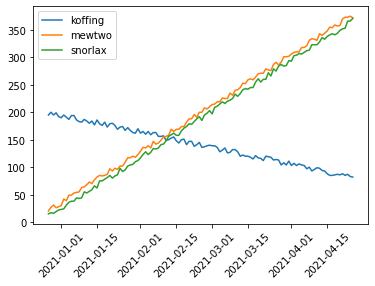

In [2]:
from typing import Mapping, List
import matplotlib.pyplot as plt

day_bucket_map: Mapping[str, List[str]] = {}
vote_count_map: Mapping[str, List[int]] = {}

for index, row in df.iterrows():
    if row.pokemon_name not in day_bucket_map:
        day_bucket_map[row.pokemon_name] = []
        vote_count_map[row.pokemon_name] = []
    day_bucket_map[row.pokemon_name].append(row.day_bucket)
    vote_count_map[row.pokemon_name].append(row.vote_count)

for pokemon_name in day_bucket_map:
    day_buckets = day_bucket_map[pokemon_name]
    vote_counts = vote_count_map[pokemon_name]
    plt.plot(day_buckets, vote_counts, label=pokemon_name)
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Transform Data untuk ML Model

In [3]:
import datetime

target_pokemon = 'mewtwo'

day_buckets = day_bucket_map[target_pokemon]
vote_counts = vote_count_map[target_pokemon]
start_date = day_buckets[0]
vote_map: Mapping[int, int] = {}
max_delta_days = 0
for index in range(len(day_buckets)):
    day_bucket = day_buckets[index]
    vote_count = vote_counts[index]
    delta = day_bucket - start_date
    delta_days = delta.days
    max_delta_days = delta_days
    vote_map[delta_days] = vote_count

# prepare data for training
x_mewtwo: List[List[int]] = []
y_mewtwo: List[int] = []
for index in range(max_delta_days):
    data_is_complete = True
    for i in range(6):
        if index + i not in vote_map:
            data_is_complete = False
            break
    if not data_is_complete:
        continue
    x = [
        vote_map[index],
        vote_map[index+1],
        vote_map[index+2],
        vote_map[index+3],
        vote_map[index+4]
    ]
    y = vote_map[index+5]
    x_mewtwo.append(x)
    y_mewtwo.append(y)

print('X', x_mewtwo)
print('Y', y_mewtwo)

X [[20, 27, 31, 26, 28], [27, 31, 26, 28, 30], [31, 26, 28, 30, 42], [26, 28, 30, 42, 39], [28, 30, 42, 39, 49], [30, 42, 39, 49, 49], [42, 39, 49, 49, 53], [39, 49, 49, 53, 54], [49, 49, 53, 54, 55], [49, 53, 54, 55, 63], [53, 54, 55, 63, 64], [54, 55, 63, 64, 68], [55, 63, 64, 68, 73], [63, 64, 68, 73, 70], [64, 68, 73, 70, 77], [68, 73, 70, 77, 82], [73, 70, 77, 82, 85], [70, 77, 82, 85, 84], [77, 82, 85, 84, 85], [82, 85, 84, 85, 87], [85, 84, 85, 87, 97], [84, 85, 87, 97, 93], [85, 87, 97, 93, 98], [87, 97, 93, 98, 96], [97, 93, 98, 96, 102], [93, 98, 96, 102, 102], [98, 96, 102, 102, 109], [96, 102, 102, 109, 117], [102, 102, 109, 117, 117], [102, 109, 117, 117, 120], [109, 117, 117, 120, 118], [117, 117, 120, 118, 123], [117, 120, 118, 123, 129], [120, 118, 123, 129, 136], [118, 123, 129, 136, 135], [123, 129, 136, 135, 139], [129, 136, 135, 139, 135], [136, 135, 139, 135, 147], [135, 139, 135, 147, 142], [139, 135, 147, 142, 144], [135, 147, 142, 144, 149], [147, 142, 144, 149,

# Membuat ML Model

In [4]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_mewtwo, y_mewtwo, random_state=1)
regr = MLPRegressor(random_state=1, max_iter=3000, activation='identity').fit(x_train, y_train)
regr.predict(x_test[:2])
regr.score(x_test, y_test)

0.9767027610929317

# Memprediksi Masa Depan

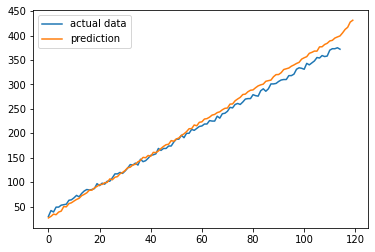

In [6]:
predictions = []

# prediksi data masa lalu
for index in range(len(x_mewtwo)):
    prediction = regr.predict([x_mewtwo[index]])
    predictions.append(prediction[0])

# prediksi data masa depan
last_x = x_mewtwo[len(x_mewtwo)-1]
last_y = y_mewtwo[len(y_mewtwo)-1]
for i in range(5):
    new_x = last_x[1:5]
    new_x.append(last_y)
    prediction = regr.predict([new_x])
    predictions.append(prediction[0])
    last_y = prediction[0]
    last_x = new_x
    

# plot data asli
plt.plot(range(len(y_mewtwo)), y_mewtwo, label="actual data")
    
# plot data baru
plt.plot(range(len(predictions)), predictions, label="prediction")
plt.legend()
plt.show()